In [2]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

mm = MinMaxScaler()
ss = StandardScaler()

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/project4/synthetic_food_dataset_imbalanced.csv'
df = pd.read_csv(file_path)

print(df.head())

     Calories    Protein        Fat      Carbs      Sugar     Fiber  \
0  290.463673  14.340084  14.152608  35.266644   4.828030  1.291432   
1  212.626748   4.080908  11.621584  23.218957  16.347814  0.130303   
2  330.695408  14.326708  19.747680  29.479164   6.251137  0.794477   
3  198.070798   9.452445   5.475896  32.097878   2.984621  1.710468   
4  274.496228   6.099547  16.256002  29.756638  17.352958  1.465676   

       Sodium  Cholesterol  Glycemic_Index  Water_Content  Serving_Size  \
0  647.553389    24.990309       81.575896      45.669118    197.570043   
1   68.572414    34.301652       69.522492      49.854415    103.833510   
2  663.171859    34.816834       62.552384      40.132866    198.989367   
3  300.749543    28.510998       68.688853      57.423461    135.714202   
4  296.314958    15.403173       70.385059      33.170460     73.019474   

  Meal_Type Preparation_Method  Is_Vegan  Is_Gluten_Free  Food_Name  
0    dinner              fried     False           F

In [5]:
#Drop NaN values from data set
df.dropna(inplace=True)

#Copy data set
AnalysisData = df

In [6]:
# Average calories based on meal type
categorical_cols = ['Meal_Type', 'Preparation_Method', 'Is_Vegan', 'Is_Gluten_Free', 'Food_Name']
AnalysisData[categorical_cols] = AnalysisData[categorical_cols].astype('category')
AnalysisData.groupby('Meal_Type')['Calories'].mean().reset_index()


Meal_Type    Calories
0  breakfast  274.325001
1     dinner  274.029361
2      lunch  272.692967
3      snack  272.468771

In [7]:
# Average Calories by Meal Type
fig = px.bar(
    AnalysisData.groupby('Meal_Type', as_index=False)['Calories'].mean(),
    x='Meal_Type',
    y='Calories',
    color='Meal_Type',
    title='Average Calories by Meal Type',
)
fig.update_layout(
    yaxis_title='Average Calories',
    xaxis_title='Meal Type',
    title_x=0.5
)
fig.show()

In [8]:
#  Calories vs Protein for Food Categories
fig = px.scatter(
    AnalysisData,
    x='Protein',
    y='Calories',
    color='Food_Name',
    symbol='Meal_Type',
    size_max=100,
    title='Calories vs. Protein by Food Item and Meal Type',
    labels={'Protein': 'Protein (g)', 'Calories': 'Calories'}
)
fig.show()

In [9]:
# Nutrient Distribution for Vegan vs Non-Vegan
nutrients = ['Calories', 'Protein', 'Fat', 'Carbs', 'Fiber']
vegan = AnalysisData[AnalysisData['Is_Vegan'] == True]
Non_vegan = AnalysisData[AnalysisData['Is_Vegan'] == False]

avg_vegan = vegan[nutrients].mean()
avg_non_vegan = Non_vegan[nutrients].mean()

NutrientData = pd.DataFrame({'Vegan': avg_vegan, 'Non-Vegan': avg_non_vegan})
# Reshape the DataFrame for Plotly (from wide to long format)
NutrientData_long = NutrientData.reset_index().melt(
    id_vars='index',
    var_name='Food_Type',
    value_name='Average_Value'
).rename(columns={'index': 'Nutrient'})

# Create the bar plot
fig = px.bar(
    NutrientData_long,
    x='Nutrient',
    y='Average_Value',
    color='Food_Type',
    barmode='group',
    title='Nutrient Comparison: Vegan vs Non-Vegan Foods',
    labels={'Average_Value': 'Average Value'}
)
fig.update_layout(
    xaxis_title='Nutrient',
    yaxis_title='Average Value',
)
fig.show()

In [10]:
# Glycemic Index vs Sugar Content by Meal Type
fig = px.scatter(
    AnalysisData,
    x='Sugar',
    y='Glycemic_Index',
    color='Meal_Type',
    size='Calories',
    size_max=50,
    title='Glycemic Index vs Sugar Content by Meal Type',
    labels={
        'Sugar': 'Sugar (g)',
        'Glycemic_Index': 'Glycemic Index'
    }
)
fig.update_layout(
    xaxis_title='Sugar (g)',
    yaxis_title='Glycemic Index'
)
fig.show()


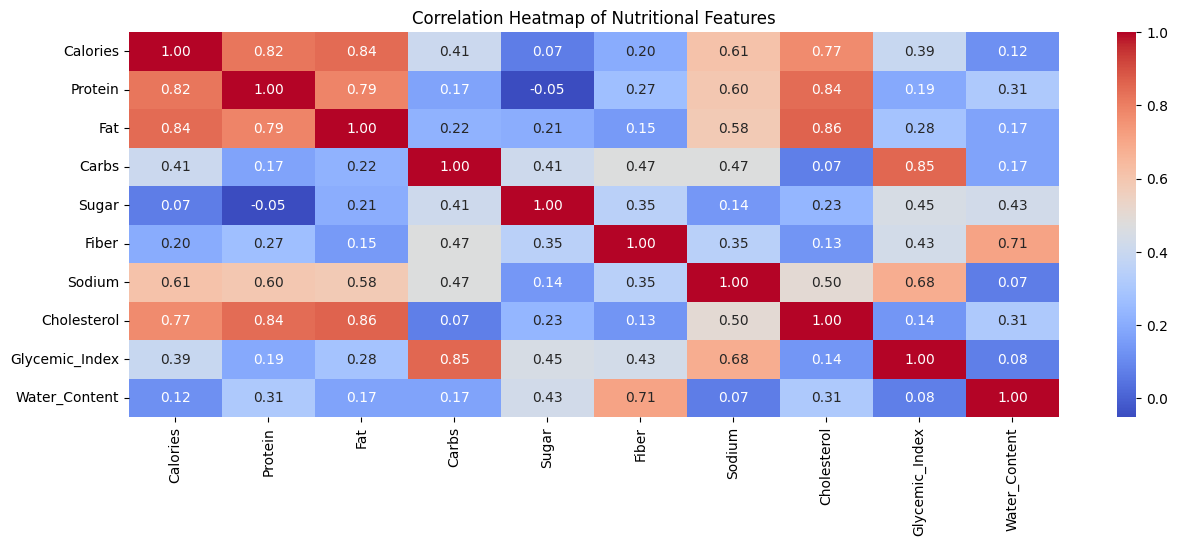

In [11]:
# Correlation Heatmap of Nutritional Features
nutritional_cols = ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber',
                    'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content']
plt.figure(figsize=(15, 5))
sns.heatmap(AnalysisData[nutritional_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Nutritional Features')
plt.show()


In [12]:
# ****** Balanced Meal Recommendation ******
recommended = AnalysisData[
    (AnalysisData['Calories'] >= 200) & (AnalysisData['Calories'] <= 350) &
    (AnalysisData['Protein'] >= 10) &
    (AnalysisData['Fiber'] >= 2) &
    (AnalysisData['Sugar'] <= 6)
]

# Assuming AnalysisData is a DataFrame already loaded
macros = ['Protein', 'Fat', 'Carbs']
df_macros = AnalysisData[macros]

# Melt the dataframe to long format for Plotly Express
df_long = df_macros.melt(var_name='Macronutrient', value_name='Amount (grams)')

# Create box plot
fig = px.box(df_long, x='Macronutrient', y='Amount (grams)', title='Macronutrient Distribution')
fig.show()


In [13]:
# Education: Healthier vs. Less Healthy Criteria
# Define healthier as low sugar, high fiber, lower calories
AnalysisData['Health_Score'] = (1/AnalysisData['Calories']) + AnalysisData['Fiber'] - (AnalysisData['Sugar']/10)
AnalysisDatasorted = AnalysisData.sort_values("Health_Score", ascending=False)
AnalysisDatasorted[['Food_Name', 'Calories', 'Fiber', 'Sugar', 'Health_Score']].head()



Food_Name     Calories      Fiber      Sugar  Health_Score
29385    Burger  1289.956763  18.891993  78.548162     11.037952
10608     Steak  1289.956763  18.891993  78.548162     11.037952
14546     Pizza  1289.956763  18.891993  78.548162     11.037952
20167     Donut  1289.956763  18.891993  78.548162     11.037952
1520      Pizza  1289.956763  18.891993  78.548162     11.037952

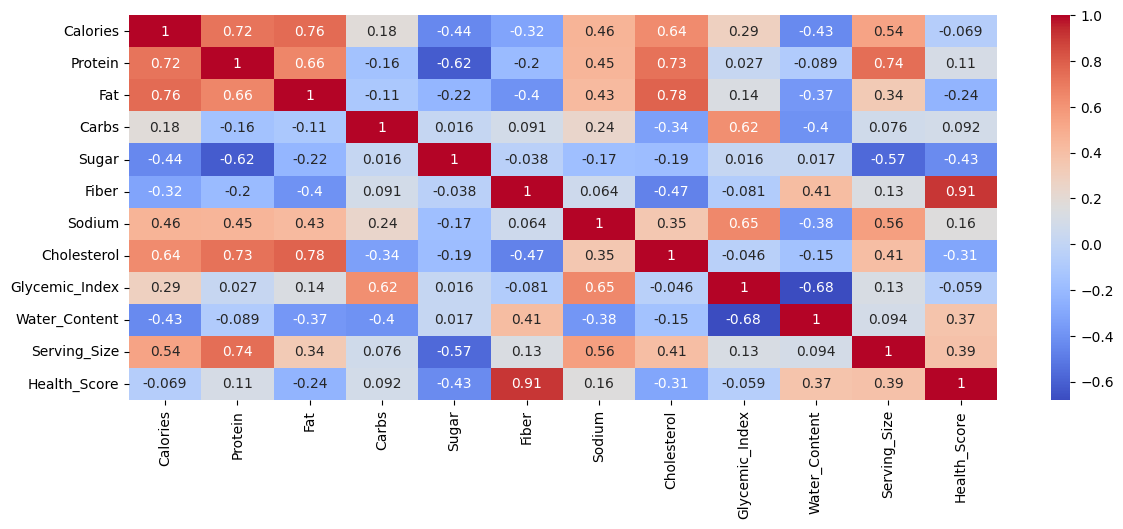

In [14]:
#cap outliers using IQR method
#Instead of removing outliers, limit them to maximum or minimum threshold

def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)   # Q1 and Q3 are the 25th and 75th percentiles
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1                 # IQR is the Interquartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR  # lower_bound and upper_bound are thresholds used to detect outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                  np.where(df[col] > upper_bound, upper_bound, df[col]))   # Cap the Outliers
    return df

#If a value in the column is below the lower bound, it's set to lower_bound.
#If a value is above the upper bound, it's set to upper_bound.
#If it's within bounds, it stays unchanged.
#This process is often called winsorizing — it reduces the impact of outliers without deleting data.

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
caped_Data = cap_outliers(df, numeric_cols)

cr = caped_Data[numeric_cols].corr()
plt.figure(figsize=(14, 5))
sns.heatmap(cr, cmap= 'coolwarm', annot= True)
plt.show()

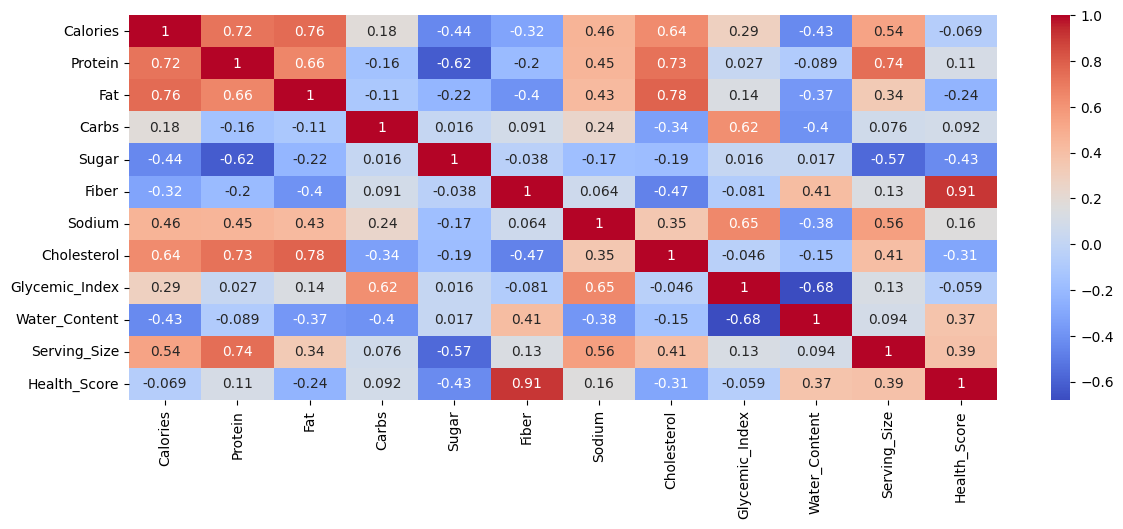

In [15]:
#Normalize Numerical Features
scaler = StandardScaler()
caped_Data[numeric_cols] = scaler.fit_transform(caped_Data[numeric_cols])

cr = caped_Data[numeric_cols].corr()
plt.figure(figsize=(14, 5))
sns.heatmap(cr, cmap= 'coolwarm', annot= True)
plt.show()


In [16]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(caped_Data[numeric_cols])

df_pca_encoded = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])

#Copy dataset
RData=caped_Data

In [17]:
# Label Encoding
labels = caped_Data[['Meal_Type','Preparation_Method','Is_Vegan','Is_Gluten_Free','Food_Name']]
labels.head()
labels = labels.astype(str)
encoded_labels = labels.copy()
labels = labels.drop('Food_Name', axis=1)
label_encoder = LabelEncoder()
for col in labels.columns:
    encoded_labels[col] = label_encoder.fit_transform(labels[col])

combined_col = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'Meal_Type', 'Preparation_Method', 'Is_Vegan', 'Is_Gluten_Free', 'Food_Name']
df_pca_encoded_list = df_pca_encoded.values.tolist()
encoded_labels_list = encoded_labels.values.tolist()
# Combine both datasets row-wise
combined_data = [pca + label for pca, label in zip(df_pca_encoded_list, encoded_labels_list)]
combined_df = pd.DataFrame(combined_data, columns=combined_col)


In [18]:
# ********* LOGISTIC ALGORITHM *********
#Set value and target for the ML model
val  = combined_df.drop('Food_Name', axis = 1)
tar = combined_df['Food_Name']

# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
# Train model
model = LogisticRegression()
model.fit(traindata, trainlab)
# Predict
tr_pred = model.predict(traindata)
ts_pred = model.predict(testdata)


# Define function for classification metrics
# Use one of these depending on what you need
# average='macro' # treats all classes equally
# average='micro' # global accuracy over all predictions
# average='weighted'# accounts for class imbalance
def perfromance(lab, pred):
    a = accuracy_score(lab, pred)
    p = precision_score(lab, pred, average='macro')
    r = recall_score(lab, pred, average='macro')
    f = f1_score(lab, pred, average='macro')
    return pd.DataFrame({'Acc': [a], "Precision": [p], "recall": [r], "F1 Score": [f]})

# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)

Acc  Precision    recall  F1 Score
0  0.986273   0.989128  0.988107    0.9886

In [19]:
# ********* DECISION TREE ALGORITHM *********
#Set value and target for the ML model
val  = combined_df.drop('Food_Name', axis = 1)
tar = combined_df['Food_Name']
# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
# Model Training
dt_model = DecisionTreeClassifier(random_state= 56)
dt_model.fit(traindata, trainlab)
# Predict
tr_pred = dt_model.predict(traindata)
ts_pred = dt_model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)

Acc  Precision   recall  F1 Score
0  0.981484   0.981699  0.98227  0.981975

In [20]:
# ********* RANDOM FOREST ALGORITHM *********
#Set value and target for the ML model
val  = combined_df.drop('Food_Name', axis = 1)
tar = combined_df['Food_Name']
# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
# Model Training
rf_model = RandomForestClassifier(n_estimators= 500, random_state= 66)
rf_model.fit(traindata, trainlab)
# Predict
tr_pred = rf_model.predict(traindata)
ts_pred = rf_model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)

Acc  Precision    recall  F1 Score
0  0.987071   0.988558  0.988422  0.988478

In [21]:
# ********* K-NEAREST NEIGHBORS ALGORITHM *********
#Set value and target for the ML model
val  = combined_df.drop('Food_Name', axis = 1)
tar = combined_df['Food_Name']
# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
# Build model
Knn_model = KNeighborsClassifier(n_neighbors= 5)
Knn_model.fit(traindata, trainlab)
# Predict
tr_pred = Knn_model.predict(traindata)
ts_pred = Knn_model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)


Acc  Precision    recall  F1 Score
0  0.984038   0.986407  0.984251   0.98527

In [24]:
# ********* GRADIENT BOOSTING  ALGORITHM *********
#Set value and target for the ML model
val  = combined_df.drop('Food_Name', axis = 1)
tar = combined_df['Food_Name']
# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
# Built Model
gb_model = GradientBoostingClassifier(n_estimators= 600, random_state= 66, max_depth= 3, learning_rate= 0.01)
gb_model.fit(traindata, trainlab)
# Predict
tr_pred = gb_model.predict(traindata)
ts_pred = gb_model.predict(testdata)
# Training perfromance
print(classification_report(trainlab, tr_pred))
# Testing Performance
print(classification_report(testlab, ts_pred))

FCol = ['Meal_Type','Preparation_Method','Is_Vegan','Is_Gluten_Free']
label_encoder = LabelEncoder()
for col in FCol:
    RData[col] = label_encoder.fit_transform(RData[col])

              precision    recall  f1-score   support

       Apple       0.99      0.99      0.99      1182
      Banana       0.99      0.99      0.99       953
      Burger       0.98      0.99      0.98      3975
       Donut       1.00      1.00      1.00      3535
   Ice Cream       1.00      1.00      1.00      2412
       Pasta       1.00      1.00      1.00      3152
       Pizza       0.99      0.98      0.99      4752
       Salad       1.00      1.00      1.00       799
       Steak       1.00      1.00      1.00      1592
       Sushi       1.00      1.00      1.00      2708

    accuracy                           0.99     25060
   macro avg       0.99      0.99      0.99     25060
weighted avg       0.99      0.99      0.99     25060

              precision    recall  f1-score   support

       Apple       0.99      0.97      0.98       291
      Banana       0.97      0.99      0.98       232
      Burger       0.97      0.96      0.96       968
       Donut       1.00 

In [25]:
# ********* X-GRADIENT BOOSTING  ALGORITHM *********
#Set value and target for the ML model
val  = combined_df.drop('Food_Name', axis = 1)
tar = combined_df['Food_Name']
# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
le = LabelEncoder()
trainlab_encoded = le.fit_transform(trainlab)
# Built Model
xgb = XGBClassifier(n_estimators= 600, random_state= 66, max_depth= 3, learning_rate= 0.08)
xgb.fit(traindata, trainlab_encoded)
# Predict
tr_pred = xgb.predict(traindata)
ts_pred = xgb.predict(testdata)
# Training perfromance
print(classification_report(trainlab.astype(str), tr_pred.astype(str)))
# Testing Performance
print(classification_report(testlab.astype(str), ts_pred.astype(str)))

FCol = ['Meal_Type','Preparation_Method','Is_Vegan','Is_Gluten_Free']
label_encoder = LabelEncoder()
for col in FCol:
    RData[col] = label_encoder.fit_transform(RData[col])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
       Apple       0.00      0.00      0.00    1182.0
      Banana       0.00      0.00      0.00     953.0
      Burger       0.00      0.00      0.00    3975.0
       Donut       0.00      0.00      0.00    3535.0
   Ice Cream       0.00      0.00      0.00    2412.0
       Pasta       0.00      0.00      0.00    3152.0
       Pizza       0.00      0.00      0.00    4752.0
       Salad       0.00    

In [26]:
# ********* LOGISTIC ALGORITHM *********
#Set value and target for the ML model
val  = RData.drop('Food_Name', axis = 1)
tar = RData['Food_Name']
# train and test split
traindata, testdata, trainlab, testlab = train_test_split( val, tar, test_size= 0.20, random_state= 66)
# Train model
model = LogisticRegression()
model.fit(traindata, trainlab)
# Predict
tr_pred = model.predict(traindata)
ts_pred = model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)


Acc  Precision    recall  F1 Score
0  0.992817   0.993555  0.993243  0.993387

In [27]:
# ********* DECISION TREE ALGORITHM *********
# Model Training
dt_model = DecisionTreeClassifier(random_state= 56)
dt_model.fit(traindata, trainlab)
# Predict
tr_pred = dt_model.predict(traindata)
ts_pred = dt_model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)

Acc  Precision    recall  F1 Score
0  0.98739   0.989397  0.989255  0.989317

In [28]:
# ********* RANDOM FOREST ALGORITHM *********
# Model Training
rf_model = RandomForestClassifier(n_estimators= 500, random_state= 66)
rf_model.fit(traindata, trainlab)
# Predict
tr_pred = rf_model.predict(traindata)
ts_pred = rf_model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)

Acc  Precision   recall  F1 Score
0  0.993456   0.994726  0.99448  0.994599

In [29]:

# ********* K-NEAREST NEIGHBORS ALGORITHM *********
# Build model
Knn_model = KNeighborsClassifier(n_neighbors= 5)
Knn_model.fit(traindata, trainlab)
# Predict
tr_pred = Knn_model.predict(traindata)
ts_pred = Knn_model.predict(testdata)
# Training Perfromance
perfromance(trainlab, tr_pred)
# Testing Perfromance
perfromance(testlab, ts_pred)


Acc  Precision    recall  F1 Score
0  0.988348     0.9893  0.987776    0.9885

In [30]:
# ********* GRADIENT BOOSTING  ALGORITHM *********
# Built Model
gb_model = GradientBoostingClassifier(n_estimators= 600, random_state= 66, max_depth= 3, learning_rate= 0.01)
gb_model.fit(traindata, trainlab)
# Predict
tr_pred = gb_model.predict(traindata)
ts_pred = gb_model.predict(testdata)
# Training perfromance
print(classification_report(trainlab, tr_pred))
# Testing Performance
print(classification_report(testlab, ts_pred))


              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00      1182
      Banana       1.00      1.00      1.00       953
      Burger       0.99      1.00      0.99      3975
       Donut       1.00      1.00      1.00      3535
   Ice Cream       0.99      1.00      1.00      2412
       Pasta       1.00      1.00      1.00      3152
       Pizza       1.00      0.99      1.00      4752
       Salad       1.00      1.00      1.00       799
       Steak       1.00      1.00      1.00      1592
       Sushi       1.00      1.00      1.00      2708

    accuracy                           1.00     25060
   macro avg       1.00      1.00      1.00     25060
weighted avg       1.00      1.00      1.00     25060

              precision    recall  f1-score   support

       Apple       0.99      0.98      0.98       291
      Banana       0.98      0.99      0.98       232
      Burger       0.98      0.99      0.98       968
       Donut       1.00 

In [32]:
# ********* X-GRADIENT BOOSTING  ALGORITHM *********
# Built Model
xgb = XGBClassifier(n_estimators= 600, random_state= 66, max_depth= 3, learning_rate= 0.08)
xgb.fit(traindata, trainlab_encoded)
# Predict
tr_pred = xgb.predict(traindata)
ts_pred = xgb.predict(testdata)
# Training perfromance
print(classification_report(trainlab.astype(str), tr_pred.astype(str)))
# Testing Performance
print(classification_report(testlab.astype(str), ts_pred.astype(str)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
       Apple       0.00      0.00      0.00    1182.0
      Banana       0.00      0.00      0.00     953.0
      Burger       0.00      0.00      0.00    3975.0
       Donut       0.00      0.00      0.00    3535.0
   Ice Cream       0.00      0.00      0.00    2412.0
       Pasta       0.00      0.00      0.00    3152.0
       Pizza       0.00      0.00      0.00    4752.0
       Salad       0.00    

In [33]:
# Rename your function for clarity
def performance(lab, pred):
    a = accuracy_score(lab, pred)
    p = precision_score(lab, pred, average='macro')
    r = recall_score(lab, pred, average='macro')
    f = f1_score(lab, pred, average='macro')
    return a, p, r, f

# Create a results list
model_results = []

# Helper function to evaluate and store results
def evaluate_model(name, model, traindata, trainlab, testdata, testlab):
    tr_pred = model.predict(traindata)
    ts_pred = model.predict(testdata)

    tr_metrics = performance(trainlab, tr_pred)
    ts_metrics = performance(testlab, ts_pred)

    model_results.append({
        'Model': name,
        'Train_Accuracy': tr_metrics[0],
        'Train_Precision': tr_metrics[1],
        'Train_Recall': tr_metrics[2],
        'Train_F1': tr_metrics[3],
        'Test_Accuracy': ts_metrics[0],
        'Test_Precision': ts_metrics[1],
        'Test_Recall': ts_metrics[2],
        'Test_F1': ts_metrics[3]
    })

# Evaluate all models
evaluate_model("Logistic Regression", model, traindata, trainlab, testdata, testlab)
evaluate_model("Decision Tree", dt_model, traindata, trainlab, testdata, testlab)
evaluate_model("Random Forest", rf_model, traindata, trainlab, testdata, testlab)
evaluate_model("KNN", Knn_model, traindata, trainlab, testdata, testlab)
evaluate_model("Gradient Boosting", gb_model, traindata, trainlab, testdata, testlab)

# For XGBoost, make sure to use encoded labels
tr_pred = xgb.predict(traindata)
ts_pred = xgb.predict(testdata)
tr_pred_labels = le.inverse_transform(tr_pred)
ts_pred_labels = le.inverse_transform(ts_pred)

tr_metrics = performance(trainlab, tr_pred_labels)
ts_metrics = performance(testlab, ts_pred_labels)

model_results.append({
    'Model': "XGBoost",
    'Train_Accuracy': tr_metrics[0],
    'Train_Precision': tr_metrics[1],
    'Train_Recall': tr_metrics[2],
    'Train_F1': tr_metrics[3],
    'Test_Accuracy': ts_metrics[0],
    'Test_Precision': ts_metrics[1],
    'Test_Recall': ts_metrics[2],
    'Test_F1': ts_metrics[3]
})

# Display comparison table
comparison_df = pd.DataFrame(model_results)
print(comparison_df.sort_values('Test_Accuracy', ascending=False).reset_index(drop=True))


                 Model  Train_Accuracy  Train_Precision  Train_Recall  \
0              XGBoost        0.998404         0.998610      0.998558   
1        Random Forest        0.998404         0.998653      0.998537   
2  Logistic Regression        0.995172         0.995351      0.995081   
3    Gradient Boosting        0.997207         0.997718      0.997545   
4                  KNN        0.994773         0.994638      0.994339   
5        Decision Tree        0.998404         0.998681      0.998514   

   Train_F1  Test_Accuracy  Test_Precision  Test_Recall   Test_F1  
0  0.998584       0.994413        0.995658     0.995506  0.995579  
1  0.998594       0.993456        0.994726     0.994480  0.994599  
2  0.995210       0.992817        0.993555     0.993243  0.993387  
3  0.997629       0.992019        0.991892     0.991629  0.991756  
4  0.994486       0.988348        0.989300     0.987776  0.988500  
5  0.998596       0.987390        0.989397     0.989255  0.989317  


In [34]:
print(comparison_df.sort_values('Test_Accuracy', ascending=False).reset_index(drop=True))


                 Model  Train_Accuracy  Train_Precision  Train_Recall  \
0              XGBoost        0.998404         0.998610      0.998558   
1        Random Forest        0.998404         0.998653      0.998537   
2  Logistic Regression        0.995172         0.995351      0.995081   
3    Gradient Boosting        0.997207         0.997718      0.997545   
4                  KNN        0.994773         0.994638      0.994339   
5        Decision Tree        0.998404         0.998681      0.998514   

   Train_F1  Test_Accuracy  Test_Precision  Test_Recall   Test_F1  
0  0.998584       0.994413        0.995658     0.995506  0.995579  
1  0.998594       0.993456        0.994726     0.994480  0.994599  
2  0.995210       0.992817        0.993555     0.993243  0.993387  
3  0.997629       0.992019        0.991892     0.991629  0.991756  
4  0.994486       0.988348        0.989300     0.987776  0.988500  
5  0.998596       0.987390        0.989397     0.989255  0.989317  


In [35]:
print(comparison_df.sort_values('Test_F1', ascending=False).reset_index(drop=True))


                 Model  Train_Accuracy  Train_Precision  Train_Recall  \
0              XGBoost        0.998404         0.998610      0.998558   
1        Random Forest        0.998404         0.998653      0.998537   
2  Logistic Regression        0.995172         0.995351      0.995081   
3    Gradient Boosting        0.997207         0.997718      0.997545   
4        Decision Tree        0.998404         0.998681      0.998514   
5                  KNN        0.994773         0.994638      0.994339   

   Train_F1  Test_Accuracy  Test_Precision  Test_Recall   Test_F1  
0  0.998584       0.994413        0.995658     0.995506  0.995579  
1  0.998594       0.993456        0.994726     0.994480  0.994599  
2  0.995210       0.992817        0.993555     0.993243  0.993387  
3  0.997629       0.992019        0.991892     0.991629  0.991756  
4  0.998596       0.987390        0.989397     0.989255  0.989317  
5  0.994486       0.988348        0.989300     0.987776  0.988500  


In [36]:
best_model = comparison_df.sort_values('Test_Accuracy', ascending=False).iloc[0]
print(f"\n Best Model Based on Test Accuracy: {best_model['Model']}")
print(f"   Accuracy: {best_model['Test_Accuracy']:.4f}, F1 Score: {best_model['Test_F1']:.4f}")



 Best Model Based on Test Accuracy: XGBoost
   Accuracy: 0.9944, F1 Score: 0.9956


In [38]:
top_model = best_f1_model.iloc[0]
print(f"\n Best Model Based on Test F1 Score:")
print(f"   Model: {top_model['Model']}")
print(f"   Accuracy: {top_model['Test_Accuracy']:.4f}")
print(f"   Precision: {top_model['Test_Precision']:.4f}")
print(f"   Recall: {top_model['Test_Recall']:.4f}")
print(f"   F1 Score: {top_model['Test_F1']:.4f}")



 Best Model Based on Test F1 Score:
   Model: XGBoost
   Accuracy: 0.9944
   Precision: 0.9957
   Recall: 0.9955
   F1 Score: 0.9956
